In [1]:
# imports
import requests
import json
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time

%matplotlib inline

In [34]:
def scrape_mlb_standings(year, df, k_cols):
    '''scrapes mlb standings data from baseball reference'''

    # instantiate dict, list as temporary data holders
    s_list = []
    s_dict = {}
    s_dict['Yr'] = year

    # set up link, request website, and create BeautifulSoup object
    link = 'http://www.baseball-reference.com/leagues/MLB/' + str(year) + '-standings.shtml'
    r = requests.get(link)
    b = BeautifulSoup(r.text, 'lxml')

    # add column headers based on table
    s_table = b.find_all('table', {'class':'sortable  stats_table'})[0]
    s_headers = s_table.find_all('tr')[0].find_all('th')
    cols = []
    for header in s_headers:
        cols.append(header.text)
        s_dict[header.text] = None

    # loop through rows in table and load data to dictionary
    s_rows = s_table.find_all('tr')[1:-1]
    for row in s_rows:
        data = row.find_all('td')
        for col in cols:
            if col == 'Tm':
                s_dict[col] = data[cols.index(col)].find('a')['title']
            else:
                s_dict[col] = data[cols.index(col)].text
        s_list.append(s_dict.copy())

    # set up dataframe with data and only keep relevant columns
    cols.append('Yr')
    df_temp = pd.DataFrame(s_list, columns = cols)
    df_temp = df_temp[k_cols]

    # append temporary dataframe to full dataframe
    df = df.append(df_temp, ignore_index = True)

    return df

def scrape_standings(years, df, k_cols):
    ''' Loops through years and scrapes specified columns'''

    for year in years:
        df = scrape_mlb_standings(year, df, k_cols)
        time.sleep(1)
    
    return df

    
cols = ['Yr','Tm','Lg','W','L','W-L%','Home','Road']
df = pd.DataFrame({}, columns = cols)
df = scrape_standings(range(1901,2017), df, cols)

df.head()

,Yr,Tm,Lg,W,L,W-L%,Home,Road
0,1901,Pittsburgh Pirates,NL,90,49,.647,45-24,45-25
1,1901,Chicago White Sox,AL,83,53,.610,49-21,34-32
2,1901,Philadelphia Phillies,NL,83,57,.593,46-23,37-34
3,1901,Boston Americans,AL,79,57,.581,49-20,30-37
4,1901,Brooklyn Superbas,NL,79,57,.581,43-25,36-32


In [52]:
# add unique identifier for team/season combo
df['Id'] = df['Yr'].map(str) + '_' + df['Tm']

# split up home & road records into individual columns
df['HWin'] = df['Home'].map(lambda x: x.split('-')[0])
df['HLose'] = df['Home'].map(lambda x: x.split('-')[1])
df['RWin'] = df['Road'].map(lambda x: x.split('-')[0])
df['RLose'] = df['Road'].map(lambda x: x.split('-')[1])

# updating datatypes
n_cols = ['Yr','W','L','HWin','HLose','RWin','RLose']
for col in n_cols:
    df[col] = df[col].astype(int)

df.head()

,Yr,Tm,Lg,W,L,W-L%,Home,Road,Id,HWin,HLose,RWin,RLose,HWin%,RWin%,HBetter%
0,1901,Pittsburgh Pirates,NL,90,49,.647,45-24,45-25,1901_Pittsburgh Pirates,45,24,45,25,0.652174,0.642857,0.014493
1,1901,Chicago White Sox,AL,83,53,.610,49-21,34-32,1901_Chicago White Sox,49,21,34,32,0.700000,0.515152,0.358824
2,1901,Philadelphia Phillies,NL,83,57,.593,46-23,37-34,1901_Philadelphia Phillies,46,23,37,34,0.666667,0.521127,0.279279
3,1901,Boston Americans,AL,79,57,.581,49-20,30-37,1901_Boston Americans,49,20,30,37,0.710145,0.447761,0.585990
4,1901,Brooklyn Superbas,NL,79,57,.581,43-25,36-32,1901_Brooklyn Superbas,43,25,36,32,0.632353,0.529412,0.194444


In [55]:
def add_metrics(df):
    '''Adds simple home & road winning percentages to df'''
    df['HWin%'] = df['HWin'] / (df['HWin'] + df['HLose'])
    df['RWin%'] = df['RWin'] / (df['RWin'] + df['RLose'])
    df['HBetter%'] = (df['HWin%'] / df['RWin%'] - 1) * 100
    
    return df

df = add_metrics(df)

df.head()

,Yr,Tm,Lg,W,L,W-L%,Home,Road,Id,HWin,HLose,RWin,RLose,HWin%,RWin%,HBetter%
0,1901,Pittsburgh Pirates,NL,90,49,.647,45-24,45-25,1901_Pittsburgh Pirates,45,24,45,25,0.652174,0.642857,1.449275
1,1901,Chicago White Sox,AL,83,53,.610,49-21,34-32,1901_Chicago White Sox,49,21,34,32,0.700000,0.515152,35.882353
2,1901,Philadelphia Phillies,NL,83,57,.593,46-23,37-34,1901_Philadelphia Phillies,46,23,37,34,0.666667,0.521127,27.927928
3,1901,Boston Americans,AL,79,57,.581,49-20,30-37,1901_Boston Americans,49,20,30,37,0.710145,0.447761,58.599034
4,1901,Brooklyn Superbas,NL,79,57,.581,43-25,36-32,1901_Brooklyn Superbas,43,25,36,32,0.632353,0.529412,19.444444


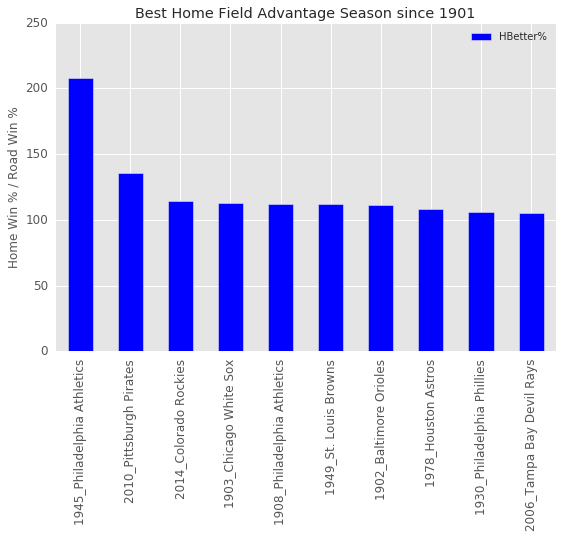

In [86]:
# visualization

# set the style
plt.style.use('ggplot')

# best home field advantage seasons
ax = df.sort_values(by='HBetter%', ascending=False)[0:10].plot(x='Id', y='HBetter%', kind='bar',
        title='Best Home Field Advantage Season since 1901')
ax.set_ylabel("Home Win % / Road Win %")
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('BestHFavpct.png', bbox_inches='tight')

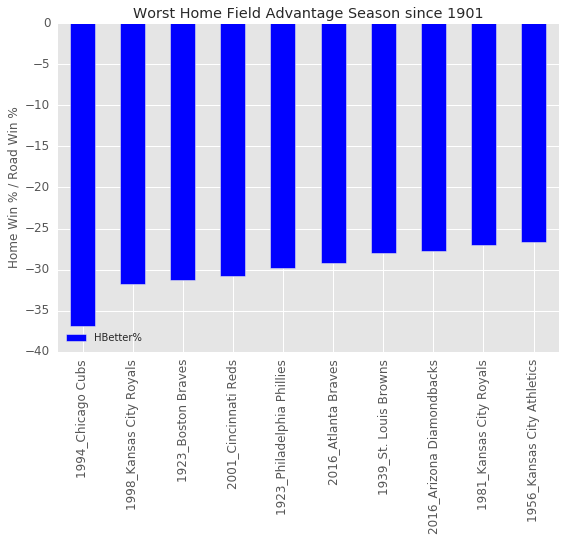

In [87]:
# worst home field advantage seasons
ax = df.sort_values(by='HBetter%', ascending=True)[0:10].plot(x='Id', y='HBetter%', kind='bar',
        title='Worst Home Field Advantage Season since 1901')
ax.set_ylabel("Home Win % / Road Win %")
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=12)

highest three years: [1917 1948 1923] 

lowest three years: [1931 1902 1978] 

average % improvement: 18.527534212413578


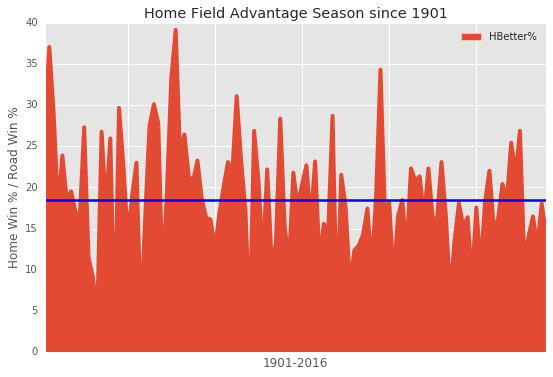

In [121]:
# has home field advantage been improving, decreasing, or stable over time?
df_year = df.groupby('Yr')['HWin','HLose','RWin','RLose'].sum().reset_index()
df_year = add_metrics(df_year)

# create plot
ax = df_year.plot(x='Yr', y='HBetter%', kind='area',
        title='Home Field Advantage Season since 1901')
ax.set_ylabel("Home Win % / Road Win %")
ax.set_xlabel("1901-2016")
ax.tick_params(axis='x', which='both', labelbottom='off')
ax.axhline(y=18.527, color='blue', linewidth=2.5)

# highest three years?
print('highest three years:', 
      df_year.sort_values('HBetter%', ascending=True)['Yr'][0:3].values, '\n')

# lowest three years?
print('lowest three years:', 
      df_year.sort_values('HBetter%', ascending=False)['Yr'][0:3].values, '\n')

# average % improvement for home field?
print('average % improvement:', df_year['HBetter%'].mean())

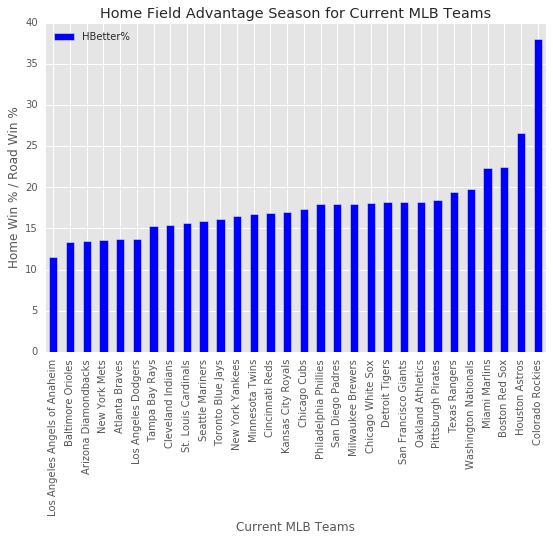

In [133]:
# of current mlb teams, which has had the best home field advantage?
current_teams = df[df.Yr == 2016].Tm.unique()

df_teams = df.copy()
df_teams['Cur'] = df_teams['Tm'].map(lambda x: x in current_teams)
df_teams = df_teams[df_teams.Cur == True]
df_teams = df_teams.groupby('Tm')['HWin','HLose','RWin','RLose'].sum().reset_index()
df_teams = add_metrics(df_teams)

# create plot
ax = df_teams.sort_values('HBetter%').plot(x='Tm', y='HBetter%', kind='bar',
        title='Home Field Advantage Season for Current MLB Teams')
ax.set_ylabel("Home Win % / Road Win %")
ax.set_xlabel("Current MLB Teams")

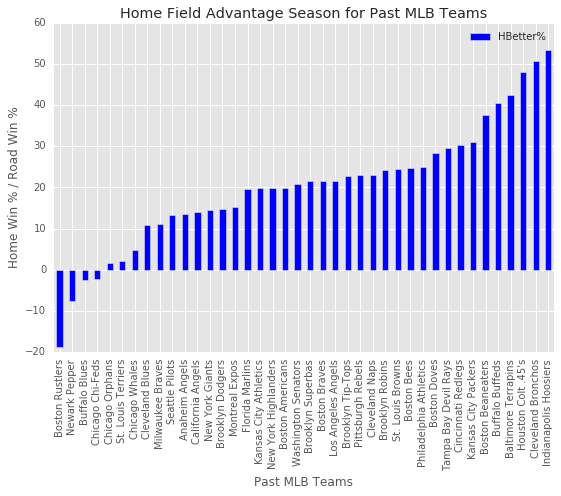

In [135]:
# of past mlb teams, which has had the best home field advantage?
df_teams = df.copy()
df_teams['Cur'] = df_teams['Tm'].map(lambda x: x in current_teams)
df_teams = df_teams[df_teams.Cur == False]
df_teams = df_teams.groupby('Tm')['HWin','HLose','RWin','RLose'].sum().reset_index()
df_teams = add_metrics(df_teams)

# create plot
ax = df_teams.sort_values('HBetter%').plot(x='Tm', y='HBetter%', kind='bar',
        title='Home Field Advantage Season for Past MLB Teams')
ax.set_ylabel("Home Win % / Road Win %")
ax.set_xlabel("Past MLB Teams")

In [136]:
df[df.Tm == "Indianapolis Hoosiers"]

,Yr,Tm,Lg,W,L,W-L%,Home,Road,Id,HWin,HLose,RWin,RLose,HWin%,RWin%,HBetter%
210,1914,Indianapolis Hoosiers,FL,88,65,.575,53-23,35-42,1914_Indianapolis Hoosiers,53,23,35,42,0.697368,0.454545,53.421053
